Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Kaggle Challenge, Module 4

- get and interpret the **confusion matrix** for classification models
- use classification metrics: **precision, recall**
- understand the relationships between precision, recall, **thresholds, and predicted probabilities**, to help **make decisions and allocate budgets**

### Setup

Run the code cell below. You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab.

Libraries

- category_encoders
- ipywidgets
- matplotlib
- numpy
- pandas
- scikit-learn
- seaborn

In [1]:
# Three musketeers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
import plotly.express as px
import plotly.figure_factory as ff

In [2]:
# Set pandas display options to allow for more columns and rows
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 500)

In [6]:
DATA_PATH = '/Users/Tobias/workshop/dasci/sprints/06-Kaggle_Challenge/DS-Unit-2-Kaggle-Challenge/data/'

---

# Get and interpret the confusion matrix for classification models

## Overview

First, load the Tanzania Waterpumps data and fit a model. (This code isn't new, we've seen it all before.)

In [8]:
%matplotlib inline
import category_encoders as ce
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier

In [9]:
def wrangle(X):
    """Wrangles train, validate, and test sets in the same way"""
    X = X.copy()

    # Convert date_recorded to datetime
    X['date_recorded'] = pd.to_datetime(X['date_recorded'], infer_datetime_format=True)
    
    # Extract components from date_recorded, then drop the original column
    X['year_recorded'] = X['date_recorded'].dt.year
    X['month_recorded'] = X['date_recorded'].dt.month
    X['day_recorded'] = X['date_recorded'].dt.day
    X = X.drop(columns='date_recorded')
    
    # Engineer feature: how many years from construction_year to date_recorded
    X['years'] = X['year_recorded'] - X['construction_year']    
    
    # Drop recorded_by (never varies) and id (always varies, random)
    unusable_variance = ['recorded_by', 'id']
    X = X.drop(columns=unusable_variance)
    
    # Drop duplicate columns
    duplicate_columns = ['quantity_group']
    X = X.drop(columns=duplicate_columns)
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these like null values
    X['latitude'] = X['latitude'].replace(-2e-08, np.nan)
    
    # When columns have zeros and shouldn't, they are like null values
    cols_with_zeros = ['construction_year', 'longitude', 'latitude', 'gps_height', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)
        
    return X

In [10]:
# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

# Split train into train & val. Make val the same size as test.
target = 'status_group'
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

# Wrangle train, validate, and test sets in the same way
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

# Arrange data into X features matrix and y target vector
X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]
X_test = test

In [11]:
# Make pipeline!
pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    SimpleImputer(strategy='mean'), 
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on val
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)
print('Validation Accuracy', accuracy_score(y_val, y_pred))

Validation Accuracy 0.8140409527789386


## Follow Along

[Scikit-Learn User Guide — Confusion Matrix](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix)

In [12]:
# This is hard to read
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[7005,  171,  622],
       [ 555,  332,  156],
       [1098,   68, 4351]])

In [13]:
# We need to get labels
from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

In [10]:
# Scikit-learn docs have an example plot_confusion_matrix function:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

# The output looks good, but the code is long and hard to understand.
# It's written just with numpy and matplotlib.

# We can write our own function using pandas and seaborn.
# The code will be shorter and easier to understand.

# Let's write the function iteratively

# 1. Check that our labels are correct

def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    return columns, index

plot_confusion_matrix(y_val, y_pred)

(['Predicted functional',
  'Predicted functional needs repair',
  'Predicted non functional'],
 ['Actual functional',
  'Actual functional needs repair',
  'Actual non functional'])

In [11]:
# 2. Make it a pandas dataframe
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return table

plot_confusion_matrix(y_val, y_pred)

,Predicted functional,Predicted functional needs repair,Predicted non functional
Actual functional,7005,171,622
Actual functional needs repair,555,332,156
Actual non functional,1098,68,4351


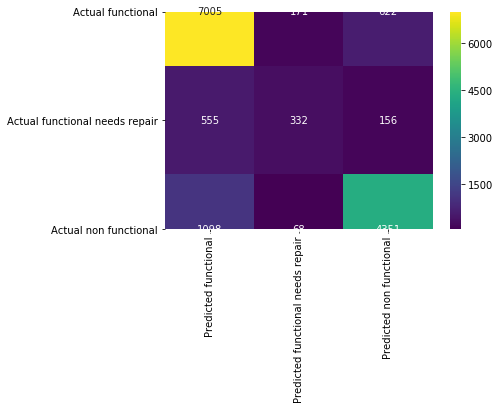

In [8]:
# 3. Plot a heatmap
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    table = pd.DataFrame(confusion_matrix(y_true, y_pred), 
                         columns=columns, index=index)
    return sns.heatmap(table, annot=True, fmt='d', cmap='viridis')

plot_confusion_matrix(y_val, y_pred);

In [22]:
# 3.2 Plot a heatmap with plotly
def plot_confusion_matrix(y_true, y_pred):
    labels = unique_labels(y_true)
    columns = [f'Predicted {label}' for label in labels]
    index = [f'Actual {label}' for label in labels]
    z = confusion_matrix(y_true, y_pred)
    fig = ff.create_annotated_heatmap(z, x=columns, y=index, colorscale="Viridis")
    fig.update_yaxes(autorange="reversed")    
    fig.show()

plot_confusion_matrix(y_val, y_pred)

#### How many correct predictions were made?

In [16]:
7005 + 332 + 4351

11688

#### How many total predictions were made?

In [10]:
7005 + 171 + 622 + 555 + 332 + 156 + 1098 + 68 + 4351

14358

#### What was the classification accuracy?

In [11]:
correct_predictions = 11688
total_predictions = 14358
correct_predictions / total_predictions

0.8140409527789386

In [12]:
accuracy_score(y_val, y_pred)

0.8140409527789386

In [13]:
sum(y_pred == y_val) / len(y_pred)

0.8140409527789386

---
---

# Use classification metrics: precision, recall

## Overview

[Scikit-Learn User Guide — Classification Report](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-report)

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_val, y_pred))

precision    recall  f1-score   support

             functional       0.81      0.90      0.85      7798
functional needs repair       0.58      0.32      0.41      1043
         non functional       0.85      0.79      0.82      5517

               accuracy                           0.81     14358
              macro avg       0.75      0.67      0.69     14358
           weighted avg       0.81      0.81      0.81     14358



#### Wikipedia, [Precision and recall](https://en.wikipedia.org/wiki/Precision_and_recall)

> Both precision and recall are based on an understanding and measure of relevance.

> Suppose a computer program for recognizing dogs in photographs identifies 8 dogs in a picture containing 12 dogs and some cats. Of the 8 identified as dogs, 5 actually are dogs (true positives), while the rest are cats (false positives). The program's precision is 5/8 while its recall is 5/12.

> High precision means that an algorithm returned substantially more relevant results than irrelevant ones, while high recall means that an algorithm returned most of the relevant results.

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/2/26/Precisionrecall.svg/700px-Precisionrecall.svg.png" width="400">

## Follow Along

#### [We can get precision & recall from the confusion matrix](https://en.wikipedia.org/wiki/Precision_and_recall#Definition_(classification_context))

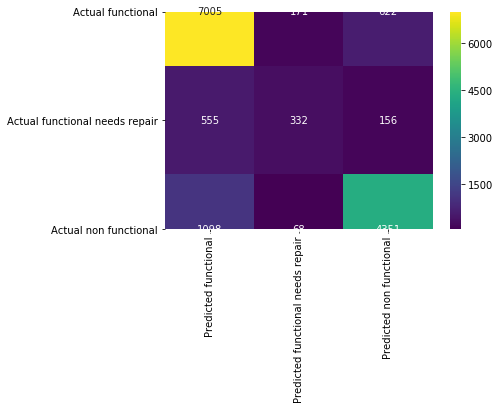

In [15]:
plot_confusion_matrix(y_val, y_pred);

#### How many correct predictions of "non functional"?

> precision and recall are for one class at a time

In [19]:
correct_predictions_nonfunctional = 4351
correct_predictions_nonfunctional

4351

#### How many total predictions of "non functional"?

In [18]:
total_predictions_nonfunctional = 4351 + 156 + 622
total_predictions_nonfunctional

5129

#### What's the precision for "non functional"?

In [20]:
correct_predictions_nonfunctional / total_predictions_nonfunctional

0.8483135114057321

In [21]:
print(classification_report(y_val, y_pred))

                         precision    recall  f1-score   support

             functional       0.81      0.90      0.85      7798
functional needs repair       0.58      0.32      0.41      1043
         non functional       0.85      0.79      0.82      5517

               accuracy                           0.81     14358
              macro avg       0.75      0.67      0.69     14358
           weighted avg       0.81      0.81      0.81     14358



#### How many actual "non functional" waterpumps?

In [22]:
actual_nonfunctional = 1098 + 68 + 4351
actual_nonfunctional

5517

#### What's the recall for "non functional"?

In [23]:
correct_predictions_nonfunctional / actual_nonfunctional

0.7886532535798442

---
---

# Understand the relationships between precision, recall, thresholds, and predicted probabilities, to help make decisions and allocate budgets

## Overview

### Imagine this scenario...

Suppose there are over 14,000 waterpumps that you _do_ have some information about, but you _don't_ know whether they are currently functional, or functional but need repair, or non-functional.

In [24]:
len(test)

14358

**You have the time and resources to go to just 2,000 waterpumps for proactive maintenance.** You want to predict, which 2,000 are most likely non-functional or in need of repair, to help you triage and prioritize your waterpump inspections.

You have historical inspection data for over 59,000 other waterpumps, which you'll use to fit your predictive model.

In [25]:
len(train) + len(val)

59400

You have historical inspection data for over 59,000 other waterpumps, which you'll use to fit your predictive model.

Based on this historical data, if you randomly chose waterpumps to inspect, then about 46% of the waterpumps would need repairs, and 54% would not need repairs.

In [26]:
y_train.value_counts(normalize=True)

functional                 0.543071
non functional             0.384241
functional needs repair    0.072688
Name: status_group, dtype: float64

In [27]:
2000 * 0.46

920.0

**Can you do better than random at prioritizing inspections?**

In this scenario, we should define our target differently. We want to identify which waterpumps are non-functional _or_ are functional but needs repair:

In [28]:
y_train = y_train != 'functional'
y_val = y_val != 'functional'
y_train.value_counts(normalize=True)

False    0.543071
True     0.456929
Name: status_group, dtype: float64

We already made our validation set the same size as our test set.

In [29]:
len(val) == len(test)

True

We can refit our model, using the redefined target.

Then make predictions for the validation set.

In [31]:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_val)

## Follow Along

#### Look at the confusion matrix:

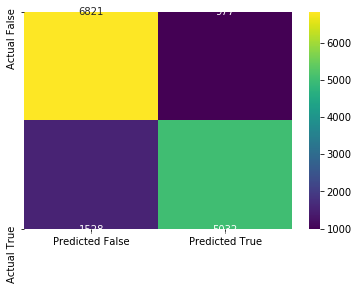

In [32]:
plot_confusion_matrix(y_val, y_pred);

#### How many total predictions of "True" ("non functional" or "functional needs repair") ?

In [33]:
5032 + 977

6009

### We don't have "budget" to take action on all these predictions

- But we can get predicted probabilities, to rank the predictions. 
- Then change the threshold, to change the number of positive predictions, based on our budget.

### Get predicted probabilities and plot the distribution

In [34]:
# Discrete predictions
pipeline.predict(X_val)

array([ True,  True, False, ..., False,  True, False])

In [35]:
# Predicted probabilities
pipeline.predict_proba(X_val)

array([[0.  , 1.  ],
       [0.26, 0.74],
       [0.9 , 0.1 ],
       ...,
       [0.91, 0.09],
       [0.41, 0.59],
       [0.98, 0.02]])

### Change the threshold

In [39]:
threshold = 0.5

y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
y_pred = y_pred_proba > threshold

y_pred

array([ True,  True, False, ..., False,  True, False])

False    8349
True     6009
dtype: int64

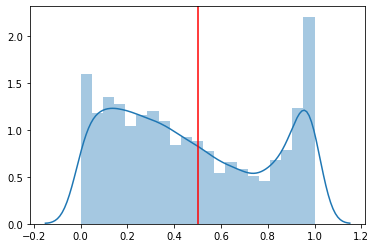

In [41]:
ax = sns.distplot(y_pred_proba)
ax.axvline(threshold, color="r")
pd.Series(y_pred).value_counts()

In [42]:
from ipywidgets import interact, fixed

def set_threshold(y_true, y_pred_proba, threshold=0.5):
    y_pred_proba = pipeline.predict_proba(X_val)[:, 1]
    y_pred = y_pred_proba > threshold
    ax = sns.distplot(y_pred_proba)
    ax.axvline(threshold, color='red')
    plt.show()
    print(classification_report(y_true, y_pred))
    plot_confusion_matrix(y_true, y_pred)
    
interact(set_threshold, 
         y_true=fixed(y_val), 
         y_pred_proba=fixed(y_pred_proba), 
         threshold=(0,1,0.02));

interactive(children=(FloatSlider(value=0.5, description='threshold', max=1.0, step=0.02), Output()), _dom_cla…

### Or, get exactly 2,000 positive predictions

Identify the 2,000 waterpumps in the validation set with highest predicted probabilities.

In [43]:
results = pd.DataFrame({"y_val": y_val, "y_pred_proba": y_pred_proba})
top2000 = results.sort_values(by='y_pred_proba', ascending=False)[:2000]

Most of these top 2,000 waterpumps will be relevant recommendations, meaning `y_val==True`, meaning the waterpump is non-functional or needs repairs.

Some of these top 2,000 waterpumps will be irrelevant recommendations, meaning `y_val==False`, meaning the waterpump is functional and does not need repairs.

Let's look at a random sample of 50 out of these top 2,000:

In [44]:
top2000.sample(n=50)

,y_val,y_pred_proba
17068,True,0.96
52420,True,0.94
3667,True,0.99
1728,True,0.95
41453,True,0.98
56308,True,0.97
41336,True,0.98
38423,True,0.99
20751,True,0.95
11423,True,0.95


So how many of our recommendations were relevant? ...

In [50]:
trips = 2000
print(f"Baseline: {trips * 0.46} waterpumps repairs in {trips} trips.")

relevant_recommendations = top2000["y_val"].sum()
print(f"With model: predict that {relevant_recommendations} waterpump repairs in {trips} trips.")

Baseline: 920.0 waterpumps repairs in 2000 trips.
With model: predict that 1972 waterpump repairs in 2000 trips.


What's the precision for this subset of 2,000 predictions?

In [52]:
precision_at_k2000 = relevant_recommendations / trips
print("Precision @ k=2000:", precision_at_k2000)

Precision @ k=2000: 0.986


### In this scenario ... 

Accuracy _isn't_ the best metric!

Instead, change the threshold, to change the number of positive predictions, based on the budget. (You have the time and resources to go to just 2,000 waterpumps for proactive maintenance.)

Then, evaluate with the precision for "non functional"/"functional needs repair".

This is conceptually like **Precision@K**, where k=2,000.

Read more here: [Recall and Precision at k for Recommender Systems: Detailed Explanation with examples](https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54)

> Precision at k is the proportion of recommended items in the top-k set that are relevant

> Mathematically precision@k is defined as: `Precision@k = (# of recommended items @k that are relevant) / (# of recommended items @k)`

> In the context of recommendation systems we are most likely interested in recommending top-N items to the user. So it makes more sense to compute precision and recall metrics in the first N items instead of all the items. Thus the notion of precision and recall at k where k is a user definable integer that is set by the user to match the top-N recommendations objective.

We asked, can you do better than random at prioritizing inspections?

If we had randomly chosen waterpumps to inspect, we estimate that only 920 waterpumps would be repaired after 2,000 maintenance visits. (46%)

But using our predictive model, in the validation set, we succesfully identified over 1,900 waterpumps in need of repair!

So we will use this predictive model with the dataset of over 14,000 waterpumps that we _do_ have some information about, but we _don't_ know whether they are currently functional, or functional but need repair, or non-functional.

We will predict which 2,000 are most likely non-functional or in need of repair.

We estimate that approximately 1,900 waterpumps will be repaired after these 2,000 maintenance visits.

So we're confident that our predictive model will help triage and prioritize waterpump inspections.